# Hex World 

Algorithms:
- Lookahead (loopy)
- Lookahead (transmission matrix)
- System of equations 

# Exact Solution Methods to Sequential Problems using HexWorld Problem from ADM

In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Tuple, List
from hex_world import HexWorld, HexMove, Hexagon
import numpy as np
from skimage import io 

GRID = [
    [ "0","0","0", "0","0","0","0", "0","0","0",],
    ["5","0","0", "X","0","0","X","X","0","0",],
    ["0","0","-10", "0","X", "0","0","0", "X","10"],
]
EAST_POLICY = [[HexMove.EAST for _ in range(10)] for _ in range(3)]
hw = HexWorld(grid=GRID, policy=EAST_POLICY)





hello
1
9
3
10
False

looks good


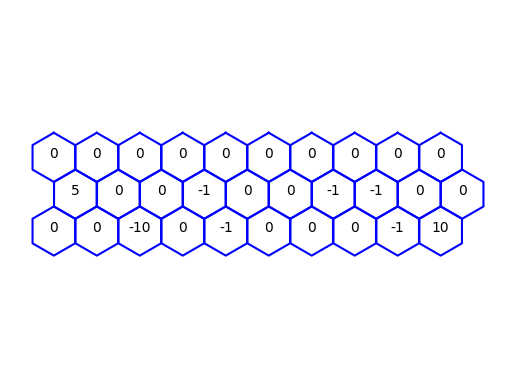

In [3]:
hw.plt_graph()

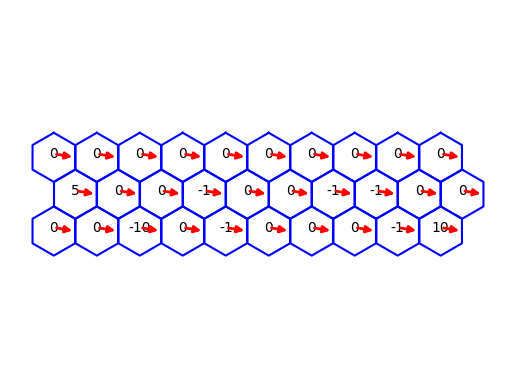

In [4]:
hw.plt_graph(show_score=True, show_policy=True)

In [5]:
T, R = hw.get_mdp()

[(0.15, None), (0.7, 0), (0.15, 0)]
[(0.15, None), (0.7, None), (0.15, 0)]
[(0.15, None), (0.7, None), (0.15, None)]
[(0.15, 10), (0.7, None), (0.15, None)]
[(0.15, 0), (0.7, 10), (0.15, None)]
[(0.15, 0), (0.7, 0), (0.15, 10)]


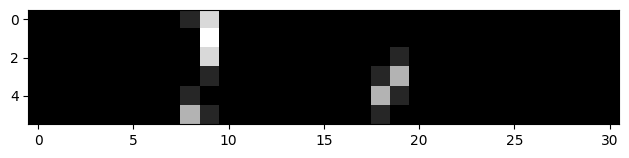

In [6]:

io.imshow(T[9])

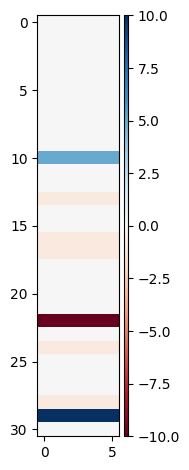

In [7]:
io.imshow(R)

# Loopy lookahead and MDP lookahead

In [8]:
from lookahead_policy_evaluation import loopy_lookahead, transmission_lookahead

hw = HexWorld(grid=GRID, policy=EAST_POLICY)
T, R = hw.get_mdp()
Ut = transmission_lookahead(T, R, hw)
Ul = loopy_lookahead(hw)
assert np.allclose(Ut, Ul)




hello
1
9
3
10
False

looks good
[(0.15, None), (0.7, 0), (0.15, 0)]
[(0.15, None), (0.7, None), (0.15, 0)]
[(0.15, None), (0.7, None), (0.15, None)]
[(0.15, 10), (0.7, None), (0.15, None)]
[(0.15, 0), (0.7, 10), (0.15, None)]
[(0.15, 0), (0.7, 0), (0.15, 10)]


In [9]:
for line in Ut.reshape(3,10):
    print(line)

[-2.00214505 -3.91056944 -4.06037871 -4.24534892 -4.94507987 -5.6562276
 -6.35118014 -7.20478574 -8.08293004 -9.5649802 ]
[         inf  -6.38715341  -7.01604152          inf  -6.25677829
  -7.24297531          inf          inf  -6.3664272  -10.36151283]
[ -6.80305146  -9.31866394          inf -10.36151283          inf
  -8.0492217   -9.37573914 -10.36151283          inf          inf]


In [10]:
for line in Ul.reshape(3,10):
    print(line)

[-2.00214505 -3.91056944 -4.06037871 -4.24534892 -4.94507987 -5.6562276
 -6.35118014 -7.20478574 -8.08293004 -9.5649802 ]
[         inf  -6.38715341  -7.01604152          inf  -6.25677829
  -7.24297531          inf          inf  -6.3664272  -10.36151283]
[ -6.80305146  -9.31866394          inf -10.36151283          inf
  -8.0492217   -9.37573914 -10.36151283          inf          inf]


inf is for hexagons without policy. This is the case for value > 0 hexagon where all inputs have the same result (reward + move to terminal state). Ut and Ul are for lookahead calculated using a loopy implementation and the transmission matrix repsectively. 

# Solving System of Equations 

Still a bit to wrokon here. Solves a system but results are not correct.

In [11]:
policy = 2
T_policy = T[:, policy, :]
mask = np.sum(T_policy, axis=-1) == 1
T_policy_cleaned = T_policy[mask][:, mask]

In [12]:
assert(np.mean(np.sum(T_policy_cleaned, axis=1)) == 1)

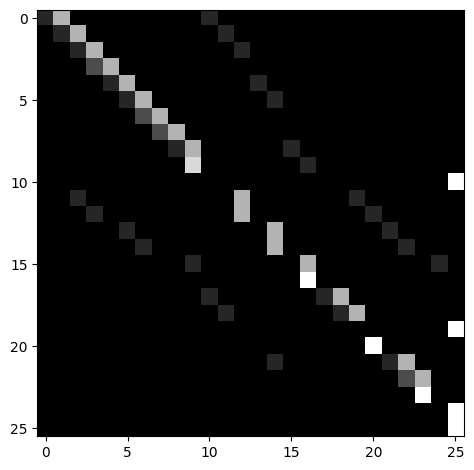

In [13]:
io.imshow(T_policy_cleaned)

In [14]:
gamma = 0.99
U_linear_eq = np.linalg.inv(np.eye(T_policy_cleaned.shape[0]) - gamma*T_policy_cleaned) @ R[mask][:,policy][...,np.newaxis]
# lets put this back in 
Ue = np.ones(len(mask))
sub = 0 
for i, mask_i in enumerate(mask):
    mask_i = mask_i * 1 # bool -> int 
    if mask_i == 0:
        sub += 1
    Ue[i] = U_linear_eq[i-sub]
# drop final
Ue = Ue[:len(Ue)-1]
Ue = np.around(Ue, decimals=3)
Ue.shape

(30,)

In [15]:
T[23, 2, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
list(T[23, 2, :]).index(1)

23

so tranission matrix under action=2 moves from state 23 to 23 with prob 1?????

this should really be index 22 

In [17]:
for line in Ue.reshape(3,10):
    print(line)

[ 0.795 -0.095  0.182  0.202  0.205  0.226  0.252  0.255  0.259 -0.   ]
[ 5.    -1.39   0.098  0.098  0.121  0.122  0.122  0.122  1.485 -0.   ]
[ -5.949  -8.381 -10.      0.      0.      0.021   0.      0.      0.
  10.   ]


U_linear_eq. fials without gamma by making matrix singular

In [18]:
for line in Ut.reshape(3,10):
    print(line)

[-2.00214505 -3.91056944 -4.06037871 -4.24534892 -4.94507987 -5.6562276
 -6.35118014 -7.20478574 -8.08293004 -9.5649802 ]
[         inf  -6.38715341  -7.01604152          inf  -6.25677829
  -7.24297531          inf          inf  -6.3664272  -10.36151283]
[ -6.80305146  -9.31866394          inf -10.36151283          inf
  -8.0492217   -9.37573914 -10.36151283          inf          inf]
